<p>
<b>Phương trình:</b><br>
$u_{t}-(1+e^{-(x-0.5)^{2}})u_{xx}=\pi^{2}(1+e^{-(x-0.5)^{2}})e^{\pi^{2}t}sin(\pi x)-\pi^{2}e^{-\pi^{2}t}sin(\pi x)$,<br>
</p>

#Thư viện

In [1]:
import tensorflow as tf
import tensorflow.keras as keras
import tensorflow.keras.layers as layers
import numpy as np
import tensorflow_probability as tfp
import math
import time

In [2]:
pi = math.pi

In [3]:
np.random.seed(70)
tf.random.set_seed(80)

#Khai báo các hàm

In [4]:
def exact_c(x):
  return 1+np.exp(-np.power(x-0.5,2))

In [5]:
def exact_u(t,x):
  return np.exp(-(np.pi**2)*t)*np.sin(np.pi*x)

In [6]:
def exact_f(t,x):
  return (np.pi**2)*(1+np.exp(-np.power(x-0.5,2)))*np.exp(-(np.pi**2)*t)*np.sin(np.pi*x)-(np.pi**2)*np.exp((-np.pi**2)*t)*np.sin(np.pi*x)

In [7]:
def L2_error_c(model,c_exact):
  n = 1000
  x = np.random.rand(n,1)

  c_e = c_exact(x)

  x = tf.convert_to_tensor(x)

  c_hat = model(x)
  c_hat = c_hat.numpy()

  error = math.sqrt(np.sum(np.square(c_e-c_hat)))

  L2 = error/n
  return L2

In [8]:
def CreateNN(arr,acti_func):
  model = keras.Sequential()
  for i in range(len(arr)):
    if i == len(arr):
      model.add(layers.Dense(arr[i]))
    else:
      model.add(layers.Dense(arr[i],activation=acti_func))
  return model

In [9]:
def grad(t,x,model):
  with tf.GradientTape(persistent = True) as tape:
    tape.watch(t)
    tape.watch(x)
    u = model(t,x)
  
  u_t = tape.gradient(u,t)
  u_x = tape.gradient(u,x)

  return u,u_t,u_x

In [10]:
def train(dataset,model_c,batch_size,epochs):
  for epoch in range(epochs):
    if (epoch>epochs*0.5 and epoch<epochs*0.75)==0:
      optimizer = tf.keras.optimizers.Adam(learning_rate = 0.005)
    elif(epoch>epochs*0.75):
      optimizer = tf.keras.optimizers.Adam(learning_rate = 0.001)
    else:
      optimizer = tf.keras.optimizers.Adam(learning_rate = 0.01)
    print("Epoch "+str(epoch+1))
    data = tf.data.Dataset.from_tensor_slices(dataset).shuffle(dataset.shape[0]).batch(batch_size)

    i = 0
    for batch in data:
      i = i + 1
      x = batch[:,0:1]
      y = batch[:,1:2]

      with tf.GradientTape() as tape:
        c_x = model_c(x)
        loss_value = tf.reduce_mean((tf.math.square(c_x-y)))

      grads = tape.gradient(loss_value, model_c.weights)
      optimizer.apply_gradients(zip(grads,model_c.weights))

      if (i%10)==0:
        print(loss_value)
  print("Complete training!")

#Tạo dữ liệu và model

In [11]:
h = 0.002
delta_t = 0.001
n = int(delta_t/delta_t)
m = int(1/h)

In [12]:
mu, sigma = 0, 0.001 # mean and standard deviation
s = np.expand_dims(np.random.normal(mu,sigma,m+1),axis = 1)

In [13]:
#trong miền
x = np.expand_dims(np.arange(0,1+h,step = h), axis = 1).astype('float32')
t = np.expand_dims(np.arange(0,2*delta_t,step = delta_t),axis = 1).astype('float32')

#u0
one = np.ones((m+1,1))*t[0]
u0 = exact_u(one,x)
#u1  
one = np.ones((m+1,1))*t[1]
u1 = exact_u(one,x)

f = []
for i in range(1,m-1):
  f_new = 0.5*(exact_f(t[1],x[i])+exact_f(t[0],x[i]))
  f.append(f_new)
f = np.array(f)

y = []
u_t = []
u_xx = []
for i in range(1,m-1):
  u_t_i = (u1[i]-u0[i])/delta_t
  u_t.append(u_t_i)
  u_xx_i = ((u0[i+1]+u0[i-1]-2*u0[i])+(u1[i+1]+u1[i-1]-2*u1[i]))/(2*h*h)
  u_xx.append(u_xx_i)

u_t = np.array(u_t) + 0.001
u_xx = np.array(u_xx) + 0.001

y = (u_t - f)/u_xx
x = x[1:y.shape[0]+1]

In [14]:
print(y.shape)

(498, 1)


In [15]:
dataset = np.concatenate((x,y),axis = 1).astype('float32')
print(dataset.shape)

(498, 2)


In [16]:
class Model2(tf.keras.Model):
  def __init__(self):
    super(Model2,self).__init__()
    self.model = keras.Sequential([
        keras.layers.Dense(1,activation="relu"),
        keras.layers.Dense(50,activation="relu"),
        keras.layers.Dense(50,activation="relu"),
        keras.layers.Dense(50,activation="relu"),
        keras.layers.Dense(50,activation="relu"),
        keras.layers.Dense(1)
    ])
  def call(self,x):
    output = self.model(x)
    return output

In [17]:
NNc = Model2()

#Training

In [18]:
epochs = 2000
loss_fn = tf.keras.losses.MeanSquaredError()
batch_size = 16
optimizer = tf.keras.optimizers.Adam(learning_rate = 0.001)

In [19]:
start = time.time()
train(dataset,NNc,batch_size,epochs)
end = time.time()

Streaming output truncated to the last 5000 lines.
tf.Tensor(0.0004537212, shape=(), dtype=float32)
tf.Tensor(0.00015009983, shape=(), dtype=float32)
tf.Tensor(0.0007318731, shape=(), dtype=float32)
Epoch 752
tf.Tensor(0.00036542106, shape=(), dtype=float32)
tf.Tensor(0.013182849, shape=(), dtype=float32)
tf.Tensor(0.00082323607, shape=(), dtype=float32)
Epoch 753
tf.Tensor(0.0021838492, shape=(), dtype=float32)
tf.Tensor(0.00018189944, shape=(), dtype=float32)
tf.Tensor(0.0016732744, shape=(), dtype=float32)
Epoch 754
tf.Tensor(0.0004512089, shape=(), dtype=float32)
tf.Tensor(0.0035368311, shape=(), dtype=float32)
tf.Tensor(0.0012911847, shape=(), dtype=float32)
Epoch 755
tf.Tensor(0.0007854145, shape=(), dtype=float32)
tf.Tensor(0.00019718302, shape=(), dtype=float32)
tf.Tensor(0.0023292915, shape=(), dtype=float32)
Epoch 756
tf.Tensor(0.0010448316, shape=(), dtype=float32)
tf.Tensor(0.00023168433, shape=(), dtype=float32)
tf.Tensor(0.0010664933, shape=(), dtype=float32)
Epoch 757
tf

#Đánh giá

In [20]:
training_time = end-start
print(training_time)

542.7411465644836


In [21]:
import matplotlib.pyplot as plt

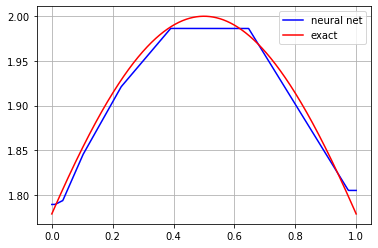

In [22]:
x_test = np.expand_dims(np.linspace(start = 0,stop = 1,num = 1000),1)
c = NNc(x_test)
c_ex = exact_c(x_test)

plt.plot(x_test.squeeze(1), c.numpy().squeeze(1),marker = 'o',markersize = 0.01,color = 'b',label = 'neural net')
plt.plot(x_test.squeeze(1), c_ex.squeeze(1),markersize = 0.01,color = 'r',label = 'exact')

plt.legend()
plt.grid()
plt.show()

In [23]:
L2_error_c(NNc,exact_c)

0.0002956632912088672